<a href="https://colab.research.google.com/github/vladislavdarii/Ship-classification-using-Machine-Learning-techniques/blob/main/06_Convolutional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1.0 Imports for Model Training
#Train and test data variables have been saved executing 0.5 to 3.2

import os
import numpy as np
import scipy.signal

#Machine learning
from keras import models,  layers
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import librosa
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

#Writing and loading variables
import pickle
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 1.1 Function: Class Accuracy Plot and Metrics

def plot_class_acc(y_val, y_pred, strr):

  # Initialize the lists for correctly and incorrectly predicted values
  correct_preds = [0, 0, 0, 0]
  incorrect_preds = [0, 0, 0, 0]

  # Loop over the samples in y_test and y_pred
  for i in range(len(y_val)):
      if y_val[i] == y_pred[i]:
          correct_preds[y_val[i]] += 1
      else:
          incorrect_preds[y_val[i]] += 1

  # Set the colors for the bars
  bar_colors = ['#009965', '#a52a2b']

  # Create the bar chart with two parts for each bar
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.bar(range(len(correct_preds)), correct_preds, color=bar_colors[0], label='Correct Predictions')
  ax.bar(range(len(incorrect_preds)), incorrect_preds, bottom=correct_preds, color=bar_colors[1], label='Incorrect Predictions')

  for i, (corr, incorr) in enumerate(zip(correct_preds, incorrect_preds)):
      ax.text(i, corr/2, str(corr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
      ax.text(i, corr + incorr/2, str(incorr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

  # Set the x-ticks and labels
  ax.set_xticks(range(len(correct_preds)))
  ax.set_xticklabels(['Class A', 'Class B', 'Class C', 'Class D'])

  # Set the labels and title
  ax.set_xlabel('Boat Type')
  ax.set_ylabel('Count')
  ax.set_title(strr)

  # Add the legend
  ax.legend()

  # Show the plot
  plt.show()

  # #Metric calculation
  # Create confusion matrix
  cm = confusion_matrix(y_val, y_pred)

  # Convert the confusion matrix to a pandas DataFrame
  confusion_matrix_df = pd.DataFrame(cm, columns=['Class A', 'Class B', 'Class C', 'Class D'])

  # Calculate metrics
  metrics_df = calculate_metrics(confusion_matrix_df.values)

  # Print the results
  print("Confusion Matrix:")
  print(confusion_matrix_df)
  print("\nMetrics:")
  print(metrics_df)

  return metrics_df, confusion_matrix_df

def calculate_metrics(confusion_matrix):
    tp = np.diagonal(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - tp
    fn = confusion_matrix.sum(axis=1) - tp
    tn = confusion_matrix.sum() - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

    metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    }
    #Get rid of NaN values
    metrics_dict = pd.DataFrame(metrics_dict)
    metrics_dict.fillna(0, inplace=True)
    return metrics_dict

#@title 5.1 Get final metrics

def metrics_avg_var(metrics):
 row = [0,1,2,3]
 Precision = []
 Recall = []
 F1_Score = []
 Accuracy = []
 Precision_var = []
 Recall_var = []
 F1_Score_var = []
 Accuracy_var = []

 for a in row:
  Precision.append(np.average([df.loc[a, 'Precision'] for df in metrics]))
  Recall.append(np.average([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score.append(np.average([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy.append(np.average([df.loc[a, 'Accuracy'] for df in metrics]))
  Precision_var.append(np.std([df.loc[a, 'Precision'] for df in metrics]))
  Recall_var.append(np.std([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score_var.append(np.std([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy_var.append(np.std([df.loc[a, 'Accuracy'] for df in metrics]))

 metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': Precision,
        'P_std' : Precision_var,
        'Recall': Recall,
        'R_std' : Recall_var,
        'F1 Score': F1_Score,
        'F1_std': F1_Score_var,
        'Accuracy': Accuracy,
        'Acc_std': Accuracy_var
    }


 return pd.DataFrame(metrics_dict)

#@title 2.1 Data Load

def dataload(datax):
  # Define the directory where the file is saved
  directory = "./drive/MyDrive/TFG/Data/"

  # Load the variables from the file
  with open(os.path.join(directory, datax), "rb") as f:
      X_train, X_test, X_val, y_train, y_test, y_val = pickle.load(f)

  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def save_model(model,modeltype,n):

  model_filename = "decision_tree_" + str(modeltype) +  "_" + str(n) + ".pkl"

  # Define the directory where you want to save the file
  directory = "./drive/MyDrive/TFG/Models/"  #change to /DTs to actually overwrite stored models
  if 1 == 0:
    # Save the variables to a file
    with open(os.path.join(directory, model_filename), "wb") as f:
        pickle.dump((model), f)
    return

#@title 3.1 Feature extraction: PSD

def get_psd():

  psd_train = []
  psd_test = []
  psd_val = []

  # Calculate the zero-crossing rate for X_train
  for audio in X_train:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024) # best so far 2*1024
    psd_train.append(S/max(S))

  psd_train = np.array(psd_train)

  # Calculate the zero-crossing rate for X_val
  for audio in X_val:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_val.append(S/max(S))

  psd_val = np.array(psd_val)

  # Calculate the zero-crossing rate for X_test
  for audio in X_test:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_test.append(S/max(S))

  psd_test = np.array(psd_test)
  return psd_train, psd_val, psd_test

#@title 3.2 Feature extraction: MFCC
def get_mfcc():
# Define the frame length and hop length in samples
  frame_length = 2000
  hop_length =  1000

  # Define the number of MFCCs to extract
  num_mfcc = 15

  # Define the sampling rate of the audio signals
  sr = 52734

  mfcc_train = []
  mfcc_val = []
  mfcc_test = []

  # Extract MFCC features for the training set
  for audio in X_train:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_train.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_train = np.array(mfcc_train)


  # Extract MFCC features for the validation set
  for audio in X_val:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_val.append(mfcc.flatten())


  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_val = np.array(mfcc_val)

  # Extract MFCC features for the test set
  for audio in X_test:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length )#,fmin = 25, fmax = 7500)
      mfcc_test.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_test = np.array(mfcc_test)
  return  mfcc_train, mfcc_val, mfcc_test

In [ ]:
#@title 2.1 Data Load

def dataload(datax):
  # Define the directory where the file is saved
  directory = "./drive/MyDrive/TFG/Data/"

  # Load the variables from the file
  with open(os.path.join(directory, datax), "rb") as f:
      X_train, X_test, X_val, y_train, y_test, y_val = pickle.load(f)

  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def save_model(model,modeltype,n):

  model_filename = "CNN_" + str(modeltype) +  "_" + str(n) + ".pkl"

  # Define the directory where you want to save the file
  directory = "./drive/MyDrive/TFG/Models/CNN/"  #change to /RF to actually overwrite stored models

  # Save the variables to a file
  with open(os.path.join(directory, model_filename), "wb") as f:
      pickle.dump((model), f)
  return

In [ ]:
#@title 3.1 Feature extraction: PSD

def get_psd():

  psd_train = []
  psd_test = []
  psd_val = []

  # Calculate the zero-crossing rate for X_train
  for audio in X_train:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024) # best so far 2*1024
    psd_train.append(S/max(S))

  psd_train = np.array(psd_train)

  # Calculate the zero-crossing rate for X_val
  for audio in X_val:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_val.append(S/max(S))

  psd_val = np.array(psd_val)

  # Calculate the zero-crossing rate for X_test
  for audio in X_test:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_test.append(S/max(S))

  psd_test = np.array(psd_test)
  return psd_train, psd_val, psd_test

In [ ]:
#@title 3.2 Feature extraction: MFCC
def get_mfcc():
# Define the frame length and hop length in samples
  frame_length = 2000
  hop_length =  1000

  # Define the number of MFCCs to extract
  num_mfcc = 15

  # Define the sampling rate of the audio signals
  sr = 52734

  mfcc_train = []
  mfcc_val = []
  mfcc_test = []

  # Extract MFCC features for the training set
  for audio in X_train:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_train.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_train = np.array(mfcc_train)


  # Extract MFCC features for the validation set
  for audio in X_val:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_val.append(mfcc.flatten())


  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_val = np.array(mfcc_val)

  # Extract MFCC features for the test set
  for audio in X_test:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length )#,fmin = 25, fmax = 7500)
      mfcc_test.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_test = np.array(mfcc_test)
  return  mfcc_train, mfcc_val, mfcc_test

In [ ]:
#@title Get CNN Raw data

def get_CNN_raw(n):

  m_raw = Sequential()
  m_raw.add(Conv1D(64,
                input_shape=[5000, 1],
                kernel_size=80,
                strides=2,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_raw.add(BatchNormalization())
  m_raw.add(MaxPooling1D(pool_size=4, strides=None))
  m_raw.add(Conv1D(128,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_raw.add(BatchNormalization())
  m_raw.add(MaxPooling1D(pool_size=4, strides=None))
  m_raw.add(Conv1D(256,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_raw.add(BatchNormalization())
  m_raw.add(MaxPooling1D(pool_size=4, strides=None))
  m_raw.add(Conv1D(512, #original 512
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_raw.add(BatchNormalization())
  m_raw.add(MaxPooling1D(pool_size=4, strides=None))
  m_raw.add(Dense(16, activation='relu')) #vlad added
  m_raw.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
  m_raw.add(Dense(4, activation='softmax'))
  m_raw.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  print(m_raw.summary())
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
  m_raw.fit(X_train, y_train, batch_size = 128, epochs = 110, validation_split=0.2, callbacks = [reduce_lr])

  y_pred = m_raw.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  metrics, matrix = plot_class_acc(y_test,y_pred,'CNN')

  save_model(m_raw,"raw",n)

  return metrics, matrix

In [ ]:
#@title Get CNN MFCC

def get_CNN_mfcc(n):
  m_mfcc = Sequential()
  m_mfcc.add(Conv1D(64,
                input_shape=[90, 1],
                kernel_size=20,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_mfcc.add(BatchNormalization())
  m_mfcc.add(MaxPooling1D(pool_size=4, strides=None))
  m_mfcc.add(Conv1D(128,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_mfcc.add(BatchNormalization())
  m_mfcc.add(MaxPooling1D(pool_size=4, strides=None))
  m_mfcc.add(Conv1D(256,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_mfcc.add(BatchNormalization())
  m_mfcc.add(MaxPooling1D(pool_size=4, strides=None))
  m_mfcc.add(Dense(16, activation='relu')) #vlad added
  m_mfcc.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
  m_mfcc.add(Dense(4, activation='softmax'))
  m_mfcc.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  print(m_mfcc.summary())
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
  m_mfcc.fit(mfcc_train, y_train, batch_size = 128, epochs = 110, validation_split=0.2, callbacks = [reduce_lr])

  y_pred = m_mfcc.predict(mfcc_test)
  y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  metrics, matrix = plot_class_acc(y_test,y_pred,'CNN')

  save_model(m_mfcc,"mfcc",n)

  return metrics, matrix

In [ ]:
#@title Get CNN PSD

def get_CNN_psd(n):
  m_psd = Sequential()
  m_psd.add(Conv1D(64,
                input_shape=[1025, 1],
                kernel_size=80,
                strides=4,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_psd.add(BatchNormalization())
  m_psd.add(MaxPooling1D(pool_size=4, strides=None))
  m_psd.add(Conv1D(128,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_psd.add(BatchNormalization())
  m_psd.add(MaxPooling1D(pool_size=4, strides=None))
  m_psd.add(Conv1D(256,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_psd.add(BatchNormalization())
  m_psd.add(MaxPooling1D(pool_size=4, strides=None))
  m_psd.add(Conv1D(512,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m_psd.add(BatchNormalization())
  m_psd.add(MaxPooling1D(pool_size=4, strides=None))
  m_psd.add(Dense(16, activation='relu')) #vlad added
  m_psd.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
  m_psd.add(Dense(4, activation='softmax'))
  m_psd.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  print(m_psd.summary())
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)

  psd_train, psd_val, psd_test = get_psd()
  m_psd.fit(psd_train, y_train, batch_size = 128, epochs = 90, validation_split=0.2, callbacks = [reduce_lr])

  y_pred = m_psd.predict(psd_test)
  y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  metrics, matrix = plot_class_acc(y_test,y_pred,'CNN')
  save_model(m_psd,"psd",n)

  return metrics, matrix

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_184 (Conv1D)         (None, 257, 64)           5184      
                                                                 
 batch_normalization_184 (Ba  (None, 257, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_184 (MaxPooli  (None, 64, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_185 (Conv1D)         (None, 64, 128)           24704     
                                                                 
 batch_normalization_185 (Ba  (None, 64, 128)          512       
 tchNormalization)                                               
                                                     

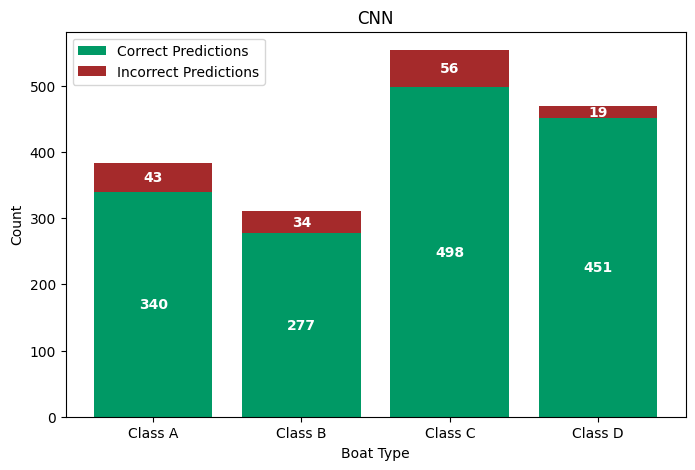

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      340        7       19       17
1        3      277       25        6
2       15       22      498       19
3        8        5        6      451

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.929   0.888     0.908     0.912
1  Class 1      0.891   0.891     0.891     0.912
2  Class 2      0.909   0.899     0.904     0.912
3  Class 3      0.915   0.960     0.937     0.912
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_188 (Conv1D)         (None, 257, 64)           5184      
                                                                 
 batch_normalization_188 (Ba  (None, 257, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_188 (MaxPooli  (None, 64, 64)   

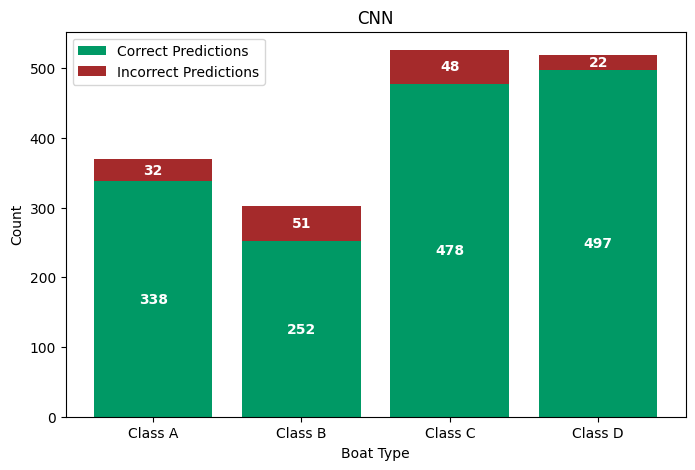

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      338        2       13       17
1       16      252       29        6
2       19       14      478       15
3        7        1       14      497

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.889   0.914     0.901     0.911
1  Class 1      0.937   0.832     0.881     0.911
2  Class 2      0.895   0.909     0.902     0.911
3  Class 3      0.929   0.958     0.943     0.911
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_192 (Conv1D)         (None, 257, 64)           5184      
                                                                 
 batch_normalization_192 (Ba  (None, 257, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_192 (MaxPooli  (None, 64, 64)   

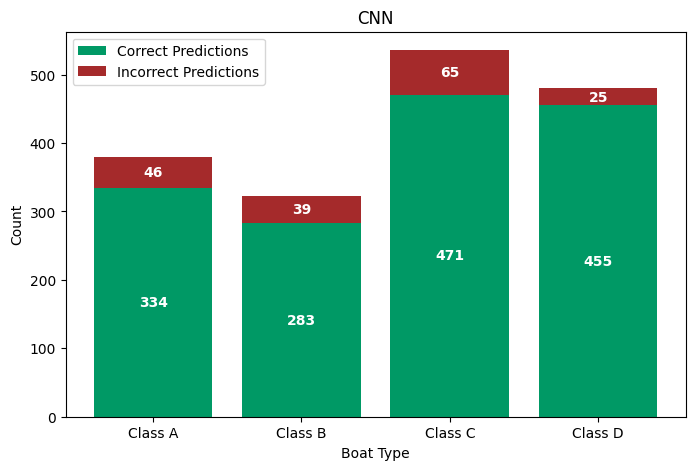

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      334       12       13       21
1       18      283       14        7
2       26       19      471       20
3       14        4        7      455

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.852   0.879     0.865     0.898
1  Class 1      0.890   0.879     0.884     0.898
2  Class 2      0.933   0.879     0.905     0.898
3  Class 3      0.905   0.948     0.926     0.898
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_196 (Conv1D)         (None, 257, 64)           5184      
                                                                 
 batch_normalization_196 (Ba  (None, 257, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_196 (MaxPooli  (None, 64, 64)   

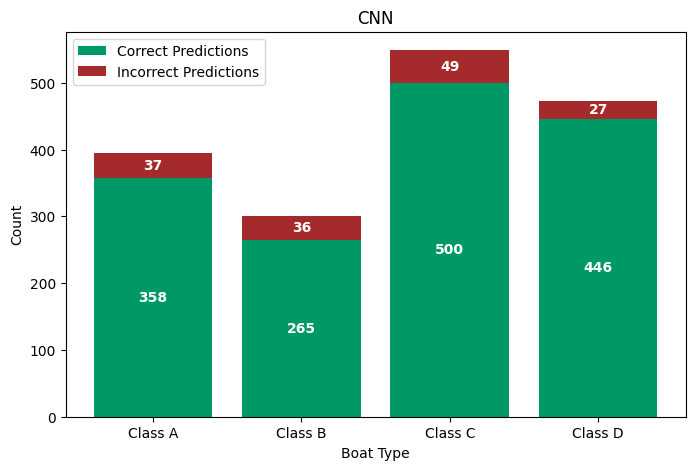

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      358        9       17       11
1        3      265       23       10
2       15       17      500       17
3       11        4       12      446

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.925   0.906     0.916     0.913
1  Class 1      0.898   0.880     0.889     0.913
2  Class 2      0.906   0.911     0.908     0.913
3  Class 3      0.921   0.943     0.932     0.913
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_200 (Conv1D)         (None, 257, 64)           5184      
                                                                 
 batch_normalization_200 (Ba  (None, 257, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_200 (MaxPooli  (None, 64, 64)   

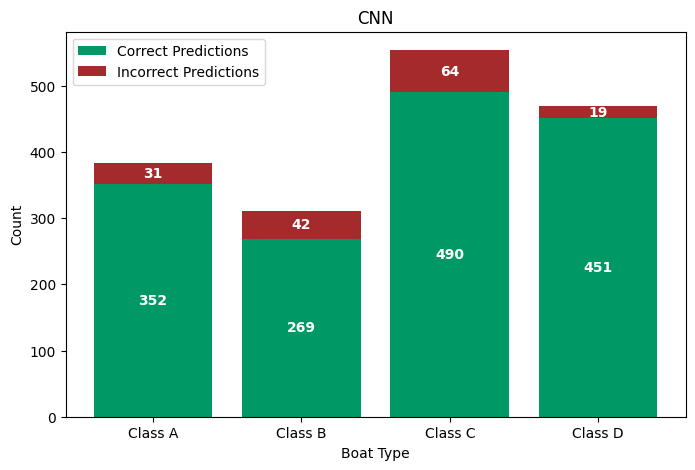

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      352        6       10       15
1        7      269       23       12
2       24       18      490       22
3       10        2        7      451

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.896   0.919     0.907     0.909
1  Class 1      0.912   0.865     0.888     0.909
2  Class 2      0.925   0.884     0.904     0.909
3  Class 3      0.902   0.960     0.930     0.909


In [ ]:
#@title 5.2 Test results extraction

# Metric activator
raw = 0
mfcc = 0
psd = 1


metrics_raw1 = []
metrics_mfcc1 = []
metrics_psd1 = []
matrix_raw = []
matrix_mfcc = []
matrix_psd = []
val = 1
data = ['data5.pkl','data2.pkl','data3.pkl','data4.pkl','data1.pkl']

for d in data:
  X_train, X_test, X_val, y_train, y_test, y_val = dataload(d)

  if raw == 1:
  # Get raw data
    metrics, matrix = get_CNN_raw(val)
    metrics_raw1.append(metrics)
    matrix_raw.append(matrix)
  if mfcc == 1:
  # Get mfcc data
    mfcc_train, mfcc_val, mfcc_test = get_mfcc()
    metrics1, matrix1 = get_CNN_mfcc(val)
    metrics_mfcc1.append(metrics1)
    matrix_mfcc.append(matrix1)
 # Get psd data
  if psd == 1:
    psd_train, psd_val, psd_test = get_psd()
    metrics2, matrix2 = get_CNN_psd(val)
    metrics_psd1.append(metrics2)
    matrix_psd.append(matrix2)
  val = val + 1

pd.options.display.float_format = '{:.3f}'.format

if raw == 1:
  metrics_raw = metrics_avg_var(metrics_raw1)
if mfcc == 1:
  metrics_mfcc = metrics_avg_var(metrics_mfcc1)
if psd == 1:
  metrics_psd = metrics_avg_var(metrics_psd1)


In [ ]:
#@title Print Table

def get_number(row,col, metrics):
 cols = ['Precision','Recall','F1 Score']
 a = metrics.at[row,col]
 highest = 0
 if col in cols:
  for value in metrics[col]:
    if value > a:
      highest = 1
  if highest == 0:
    a = "\highest{" + str(a) + "}"
 return str(a)

def print_table(metrics):

#metrics table formatting


  columns_to_format = ['Precision',
                        'Recall',
                        'F1 Score',
                          'Accuracy']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)
  columns_to_format = ['P_std','R_std','F1_std','Acc_std']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)


  print(
  "Class A                           & " + get_number(0,'Precision',metrics) + "                               & (" + get_number(0,'P_std',metrics) + ")     & " + get_number(0,'Recall',metrics) + "                         & (" + get_number(0,'R_std',metrics) + ")         & " + get_number(0,'F1 Score',metrics) + "                  & (" + get_number(0,'F1_std',metrics) + ")                   \\\\"
  " \\rowcolor[HTML]{EFEFEF} Class B                           & " + get_number(1,'Precision',metrics) + "                               & (" + get_number(1,'P_std',metrics) + ")      & " + get_number(1,'Recall',metrics) + "                         & (" + get_number(1,'R_std',metrics) + ")         & " + get_number(1,'F1 Score',metrics) + "                  & (" + get_number(1,'F1_std',metrics) + ")                  \\\\"
  "Class C                           & " + get_number(2,'Precision',metrics) + "                               & (" + get_number(2,'P_std',metrics) + ")      & " + get_number(2,'Recall',metrics) + "                        & (" + get_number(2,'R_std',metrics) + ")         & " + get_number(2,'F1 Score',metrics) + "                  & (" + get_number(2,'F1_std',metrics) + ")                  \\\\")
  print("\\rowcolor[HTML]{EFEFEF} "
  "Class D                           & " + get_number(3,'Precision',metrics) + "                              & (" + get_number(3,'P_std',metrics) + ")      & " + get_number(3,'Recall',metrics) + "                         & (" + get_number(3,'R_std',metrics) + ")         & " + get_number(3,'F1 Score',metrics) + "                  & (" + get_number(3,'F1_std',metrics) + ")                 \\\\ \midrule"
  "\\multicolumn{1}{c}{\\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \\textbf{" + get_number(3,'Accuracy',metrics) + "}         & \\textbf{(" + get_number(2,'Acc_std',metrics) + ")}  ")
  return


print_table(metrics_psd)

Class A                           & 0.898                               & (0.028)     & 0.901                         & (0.015)         & 0.899                  & (0.018)                   \\ \rowcolor[HTML]{EFEFEF} Class B                           & 0.906                               & (0.018)      & 0.869                         & (0.021)         & 0.887                  & (0.003)                  \\Class C                           & 0.913                               & (0.013)      & 0.896                        & (0.013)         & 0.905                  & (0.002)                  \\
\rowcolor[HTML]{EFEFEF} Class D                           & \highest{0.914}                              & (0.01)      & \highest{0.954}                         & (0.007)         & \highest{0.933}                  & (0.006)                 \\ \midrule\multicolumn{1}{c}{\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \t

In [ ]:
#@title Print Matrix

def get_max_matrix(matrix):
  a = 0
  pos = 5
  tp_max = 0
  for m in matrix:
    tp = sum(np.diagonal(m))
    if tp_max < tp:
      tp_max = tp
      pos = a
    a = a+1
  return pos

def get_matrix(matrix):
  matrix = matrix[get_max_matrix(matrix)]
  col = ['Class A','Class B','Class C','Class D']
  for i in list(range(4)):
    for j in list(range(4)):
      print(j,i,matrix.at[i,col[j]])

print("x y C")
get_matrix(matrix_psd)


x y C
0 0 358
1 0 9
2 0 17
3 0 11
0 1 3
1 1 265
2 1 23
3 1 10
0 2 15
1 2 17
2 2 500
3 2 17
0 3 11
1 3 4
2 3 12
3 3 446


In [ ]:
#@title NOT INCLUDED IN FDP 3.0 Feature extraction: MFCC (image 15 X 101 pixels)

import librosa
import librosa.display

sr = 52734
width = 101
n_mfcc = 101

def create_mfcc(audio_array, sampling_rate, n_mfcc=n_mfcc, n_fft=100, hop_length=50):

    # Compute the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(audio_array, n_fft=n_fft, hop_length=hop_length)

    # Convert magnitude spectrogram to MFCCs
    mfccs = librosa.feature.mfcc(S=np.abs(stft)**2, sr=sampling_rate, n_mfcc=n_mfcc)

    return mfccs

def mfcctoimg(arr, samplerate):
  nested = []
  sr = samplerate
  for x in range(len(arr)):

    ad = arr[x].flatten().astype(float)

    mfccs = create_mfcc(ad, sr)

    # Plot the MFCCs without color bar and set the size to 15 x 21 pixels
    plt.figure(figsize=(n_mfcc/100, width/100), dpi=100)
    img = librosa.display.specshow(mfccs, x_axis='time', sr=sr, hop_length=512,cmap='gray')
    plt.axis('off')  # Turn off axis labels and ticks
    plt.tight_layout()
    # Ensure the plot is drawn
    plt.draw()
    plt.show()

    # Get the pixel values of the grayscale plot directly
    plt_img_gray = img.get_array()

     # Normalize the image array (optional but recommended for training deep learning models)
    plt_img_gray = plt_img_gray.astype(float) / 255.0

    # Add the grayscale image to the list
    nested.append(plt_img_gray)

    # Close the plot to free up memory
    plt.close()
  return nested


X_train_img = mfcctoimg(X_train,sr)
X_val_img = mfcctoimg(X_val,sr)


# Convert X_val_img list to a 4D numpy array
X_val_img = np.array(X_val_img)

# Reshape X_val_img to have the shape (number_of_samples, height, width, channels)
X_val_img = X_val_img.reshape(-1, 100, width, 1)

# Convert X_train_img list to a 4D numpy array
X_train_img = np.array(X_train_img)

# Reshape X_train_img to have the shape (number_of_samples, height, width, channels)
X_train_img = X_train_img.reshape(-1, 100, width, 1)

In [ ]:
#@title 4.0 2D MFCC Convolutional model

input_shape=(15,101,1)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(4, activation='softmax'))

CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

ValueError: ignored

In [ ]:
history = CNNmodel.fit(X_train_img, y_train, epochs=20, validation_data= (X_val_img, y_val))

Epoch 1/20
172/172 [==============================] - 5s 20ms/step - loss: nan - accuracy: 0.2230 - val_loss: nan - val_accuracy: 0.2153
Epoch 2/20
172/172 [==============================] - 2s 11ms/step - loss: nan - accuracy: 0.2187 - val_loss: nan - val_accuracy: 0.2153
Epoch 3/20
172/172 [==============================] - 2s 11ms/step - loss: nan - accuracy: 0.2187 - val_loss: nan - val_accuracy: 0.2153
Epoch 4/20
172/172 [==============================] - 2s 11ms/step - loss: nan - accuracy: 0.2187 - val_loss: nan - val_accuracy: 0.2153
Epoch 5/20
172/172 [==============================] - 2s 11ms/step - loss: nan - accuracy: 0.2187 - val_loss: nan - val_accuracy: 0.2153
Epoch 6/20
172/172 [==============================] - 2s 11ms/step - loss: nan - accuracy: 0.2187 - val_loss: nan - val_accuracy: 0.2153
Epoch 7/20
172/172 [==============================] - 3s 17ms/step - loss: nan - accuracy: 0.2187 - val_loss: nan - val_accuracy: 0.2153
Epoch 8/20
172/172 [=====================

KeyboardInterrupt: ignored

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_117 (Conv1D)         (None, 257, 64)           5184      
                                                                 
 batch_normalization_117 (Ba  (None, 257, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_117 (MaxPooli  (None, 64, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_118 (Conv1D)         (None, 64, 128)           24704     
                                                                 
 batch_normalization_118 (Ba  (None, 64, 128)          512       
 tchNormalization)                                               
                                                     

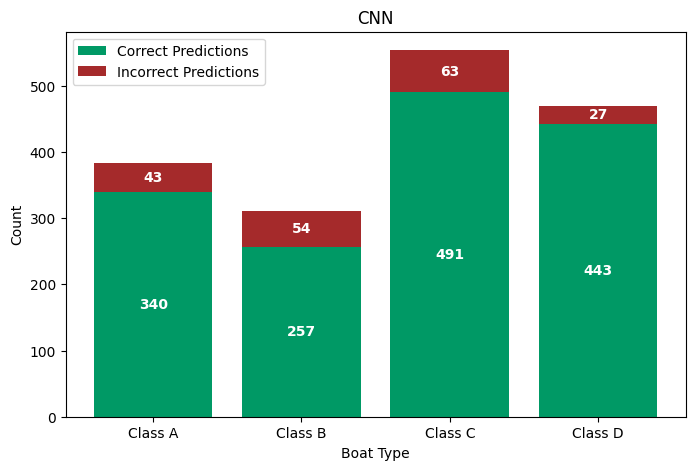

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      340        5       19       19
1       15      257       31        8
2       26       15      491       22
3       10        1       16      443

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.870   0.888     0.879     0.891
1  Class 1      0.924   0.826     0.873     0.891
2  Class 2      0.882   0.886     0.884     0.891
3  Class 3      0.900   0.943     0.921     0.891


In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = dataload('data4.pkl')
psd_train, psd_val, psd_test = get_psd()
m_psd = Sequential()
m_psd.add(Conv1D(64,
              input_shape=[1025, 1],
              kernel_size=80,
              strides=4,
              padding='same',
              kernel_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l=0.0001),
              activation='relu'))
m_psd.add(BatchNormalization())
m_psd.add(MaxPooling1D(pool_size=4, strides=None))
m_psd.add(Conv1D(128,
              kernel_size=3,
              strides=1,
              padding='same',
              kernel_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l=0.0001),
              activation='relu'))
m_psd.add(BatchNormalization())
m_psd.add(MaxPooling1D(pool_size=4, strides=None))
m_psd.add(Conv1D(256,
              kernel_size=3,
              strides=1,
              padding='same',
              kernel_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l=0.0001),
              activation='relu'))
m_psd.add(BatchNormalization())
m_psd.add(MaxPooling1D(pool_size=4, strides=None))
m_psd.add(Conv1D(512,
              kernel_size=3,
              strides=1,
              padding='same',
              kernel_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l=0.0001),
              activation='relu'))
m_psd.add(BatchNormalization())
m_psd.add(MaxPooling1D(pool_size=4, strides=None))
m_psd.add(Dense(16, activation='relu')) #vlad added
m_psd.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
m_psd.add(Dense(4, activation='softmax'))
m_psd.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
print(m_psd.summary())
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)

X_train, X_test, X_val, y_train, y_test, y_val = dataload('data1.pkl')
psd_train, psd_val, psd_test = get_psd()
m_psd.fit(psd_train, y_train, batch_size = 128, epochs = 90, validation_split=0.2, callbacks = [reduce_lr])

y_pred = m_psd.predict(psd_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
metrics, matrix = plot_class_acc(y_test,y_pred,'CNN')



In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

NameError: ignored

In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
#@title Randomized Search CNN

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.callbacks import ReduceLROnPlateau

def create_model(f1=128, kernel_size=3, strides=4, l = 0.0001, dense_units = 16):
  m = Sequential()
  m.add(Conv1D(f1,
                input_shape=[5000, 1],
                kernel_size=kernel_size,
                strides=strides,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=l),
                activation='relu'))
  m.add(BatchNormalization())
  m.add(MaxPooling1D(pool_size=4, strides=None))
  m.add(Conv1D(128,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m.add(BatchNormalization())
  m.add(MaxPooling1D(pool_size=4, strides=None))
  m.add(Conv1D(256,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m.add(BatchNormalization())
  m.add(MaxPooling1D(pool_size=4, strides=None))
  m.add(Conv1D(512, #original 512
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001),
                activation='relu'))
  m.add(BatchNormalization())
  m.add(MaxPooling1D(pool_size=4, strides=None))
  m.add(Dense(dense_units, activation='relu')) #vlad added
  m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
  m.add(Dense(4, activation='softmax'))
  m.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  print(m.summary())
  return m

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'f1': [64, 128, 254],
    'kernel_size': [60, 80, 100],
    'strides': [1,2,3,4],
    'dense_units': [10, 16, 20, 24],
    'l' : [0.0001, 0.00008, 0.00012]
}
X_train, X_test, X_val, y_train, y_test, y_val = dataload("data1.pkl")
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.0001, verbose=1)

grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='accuracy', cv=3, n_iter = 24)
grid_search.fit(X_train, y_train, batch_size = 128, epochs = 50)

#m.fit(X_train, y_train, batch_size = 128, epochs = 100, validation_split=0.2, callbacks = [reduce_lr])


<ipython-input-53-cf7e02a34aeb>:58: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_91 (Conv1D)          (None, 2500, 128)         7808      
                                                                 
 batch_normalization_91 (Bat  (None, 2500, 128)        512       
 chNormalization)                                                
                                                                 
 max_pooling1d_91 (MaxPoolin  (None, 625, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_92 (Conv1D)          (None, 625, 128)          49280     
                                                                 
 batch_normalization_92 (Bat  (None, 625, 128)         512       
 chNormalization)                                                
                                                     

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7dafec185960>,
                   n_iter=24,
                   param_distributions={'dense_units': [10, 16, 20, 24],
                                        'f1': [64, 128, 254],
                                        'kernel_size': [60, 80, 100],
                                        'l': [0.0001, 8e-05, 0.00012],
                                        'strides': [1, 2, 3, 4]},
                   scoring='accuracy')

In [ ]:
#@title Randomized Search
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

Best Parameters:  {'strides': 2, 'l': 0.0001, 'kernel_size': 80, 'f1': 64, 'dense_units': 16}
Best Accuracy: 85.26%


In [ ]:
m_raw = Sequential()
m_raw.add(Conv1D(64,
              input_shape=[5000, 1],
              kernel_size=80,
              strides=2,
              padding='same',
              kernel_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l=0.0001),
              activation='relu'))
m_raw.add(BatchNormalization())
m_raw.add(MaxPooling1D(pool_size=4, strides=None))
m_raw.add(Conv1D(128,
              kernel_size=3,
              strides=1,
              padding='same',
              kernel_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l=0.0001),
              activation='relu'))
m_raw.add(BatchNormalization())
m_raw.add(MaxPooling1D(pool_size=4, strides=None))
m_raw.add(Conv1D(256,
              kernel_size=3,
              strides=1,
              padding='same',
              kernel_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l=0.0001),
              activation='relu'))
m_raw.add(BatchNormalization())
m_raw.add(MaxPooling1D(pool_size=4, strides=None))
m_raw.add(Conv1D(512, #original 512
              kernel_size=3,
              strides=1,
              padding='same',
              kernel_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l=0.0001),
              activation='relu'))
m_raw.add(BatchNormalization())
m_raw.add(MaxPooling1D(pool_size=4, strides=None))
m_raw.add(Dense(16, activation='relu')) #vlad added
m_raw.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
m_raw.add(Dense(4, activation='softmax'))
m_raw.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
print(m_raw.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2500, 64)          5184      
                                                                 
 batch_normalization (BatchN  (None, 2500, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 625, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 625, 128)          24704     
                                                                 
 batch_normalization_1 (Batc  (None, 625, 128)         512       
 hNormalization)                                                 
                                                        